In [30]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import plotly.io as pio   
pio.kaleido.scope.mathjax = None
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import sigfig
import plotly.graph_objects as go
from scipy.stats import wilcoxon
import os,sys
# set correct wd:
cwd = os.getcwd()
if not cwd.endswith('ANALYSIS'):
    os.chdir('./bin/ANALYSIS')
    sys.path.append(os.path.abspath('.'))
output_directory = '../../output'
os.makedirs(f'{output_directory}/figures', exist_ok=True)

In [ ]:
# Accuracy comparison between HATCHet2 and ALPACA
def get_hd_hatchet_alpaca_colours(palette):
    import json
    with open(palette, "r") as f:
        palette = json.load(f)
    catgorical_palette = palette["categorical"]
    colours = {}
    colours["hd"] = catgorical_palette["c12"]
    colours["hatchet"] = catgorical_palette["c8"]
    colours["alpaca"] = catgorical_palette["c2"]
    return colours


def create_consensus_segments(df1, df2,position_columns_names=['#CHR','START','END']):
    chr_colname = position_columns_names[0]
    start_colname = position_columns_names[1]
    end_colname = position_columns_names[2]
    combined = pd.concat([
        df1[[chr_colname, start_colname]].rename(columns={start_colname: "position"}),
        df1[[chr_colname, end_colname]].rename(columns={end_colname: "position"}),
        df2[[chr_colname, start_colname]].rename(columns={start_colname: "position"}),
        df2[[chr_colname, end_colname]].rename(columns={end_colname: "position"}),
    ])
    
    combined = combined.drop_duplicates().sort_values(by=[chr_colname, "position"]).reset_index(drop=True)
    
    # Create consensus segments
    consensus = combined.copy()
    consensus[end_colname] = consensus.groupby(chr_colname)["position"].shift(-1)
    consensus = consensus.dropna().rename(columns={"position": start_colname})
    consensus = consensus[[chr_colname, start_colname, end_colname]]
    
    def map_metadata(consensus, original,metadata_columns):
        consensus = consensus.copy()
        for col in metadata_columns:
            consensus[col] = None
        
        # Map metadata by checking overlaps
        for _, row in original.iterrows():
            overlap = (consensus[chr_colname] == row[chr_colname]) & \
                      (consensus[start_colname] >= row[start_colname]) & \
                      (consensus[end_colname] <= row[end_colname])
            for col in metadata_columns:
                consensus.loc[overlap, col] = row[col]
        return consensus

    metadata_columns_df1 = [col for col in df1.columns if col not in position_columns_names]
    metadata_columns_df2 = [col for col in df2.columns if col not in position_columns_names]
    consensus_df1 = map_metadata(consensus, df1,metadata_columns_df1)
    consensus_df2 = map_metadata(consensus, df2,metadata_columns_df2)
    consensus_df1 = consensus_df1.dropna()
    consensus_df2 = consensus_df2.dropna()
    
    
    consensus_df1['segment'] = consensus_df1[position_columns_names].apply(lambda x: f'{x[chr_colname]}_{int(x[start_colname])}_{int(x[end_colname])}',axis=1)
    consensus_df2['segment'] = consensus_df2[position_columns_names].apply(lambda x: f'{x[chr_colname]}_{int(x[start_colname])}_{int(x[end_colname])}',axis=1)
    
    consensus_df1['seg_len'] = consensus_df1[end_colname] - consensus_df1[start_colname]
    consensus_df2['seg_len'] = consensus_df2[end_colname] - consensus_df2[start_colname]
    
    # remove zero-length segments:
    consensus_df1 = consensus_df1[consensus_df1['seg_len'] > 0]
    consensus_df2 = consensus_df2[consensus_df2['seg_len'] > 0]
    
    # keep only common segments:
    common_segments = set(consensus_df1['segment']).intersection(set(consensus_df2['segment']))
    consensus_df1 = consensus_df1[consensus_df1['segment'].isin(common_segments)]
    consensus_df2 = consensus_df2[consensus_df2['segment'].isin(common_segments)]
    assert consensus_df1.shape[0] == consensus_df2.shape[0]
    return consensus_df1, consensus_df2


def get_score_for_segment(segment_df_true,segment_df_model,clone_columns_true,clone_columns_model):
    set_of_predicted_cns = set(sum([x.split('|') for x in segment_df_model[clone_columns_model].values[0]],[]))
    set_of_true_cns = set(sum([x.split('|') for x in segment_df_true[clone_columns_true].values[0]],[]))
    assert len(set_of_predicted_cns) > 0
    assert len(set_of_true_cns) > 0
    seg_len = segment_df_true['seg_len'].values[0]
    recovered = len(set_of_predicted_cns.intersection(set_of_true_cns))
    all_states = len(set_of_predicted_cns.union(set_of_true_cns))
    predicted_denom = len(set_of_predicted_cns)
    true_denom = len(set_of_true_cns)
    precision = seg_len * (recovered / predicted_denom)
    recall = seg_len * (recovered / true_denom)
    accuracy = seg_len * (recovered / all_states)
    return precision, recall, accuracy


def get_metrics_per_case(model_consensus,TRUE_consensus,clone_columns_true,clone_columns_model):
    precision_list = []
    recall_list = []
    accuracy_list = []
    for segment in model_consensus['segment']:
        segment_df_model = model_consensus[model_consensus['segment']==segment]
        segment_df_true = TRUE_consensus[TRUE_consensus['segment']==segment]
        precision,recall,accuracy = get_score_for_segment(segment_df_true,segment_df_model,clone_columns_true,clone_columns_model)
        precision_list.append(precision)
        recall_list.append(recall)
        accuracy_list.append(accuracy)
    total_len = sum(model_consensus['seg_len'])
    precision = sum(precision_list)/total_len
    recall = sum(recall_list)/total_len
    accuracy = sum(accuracy_list)/total_len
    return precision,recall,accuracy


def load_H1_results(dataset_name,experiment,hatchet1_output_dir):
    wgd_results_path = f'{hatchet1_output_dir}/WGD/{dataset_name}/{experiment}/hatchet/hatchet.seg.ucn.gz'
    nowgd_results_path = f'{hatchet1_output_dir}/noWGD/{dataset_name}/{experiment}/hatchet/hatchet.seg.ucn.gz'
    if os.path.exists(wgd_results_path):
        H1_results = pd.read_csv(wgd_results_path, sep='\t')
    else:
        H1_results = pd.read_csv(nowgd_results_path, sep='\t')
    H1_results['#CHR'] = H1_results['#CHR'].apply(lambda x: x.replace('chr',''))
    H1_results['START'] = H1_results['START'].astype(int)
    H1_results['END'] = H1_results['END'].astype(int)
    H1_results.rename(columns={'cn_normal':'cn_clone100'},inplace=True)
    position_columns_names=['#CHR','START','END']
    H1_results_clones = [x for x in H1_results.columns if x.startswith('cn_')]
    H1_results = H1_results[position_columns_names + H1_results_clones].drop_duplicates() 
    return H1_results


def load_clone_HD_results(dataset_name,experiment,hatchet1_output_dir):
    wgd_results_path = f'{hatchet1_output_dir}/WGD/{dataset_name}/{experiment}/clonehd/cloneHD.BEST.results.gz'
    nowgd_results_path = f'{hatchet1_output_dir}/noWGD/{dataset_name}/{experiment}/clonehd/cloneHD.BEST.results.gz'
    if os.path.exists(wgd_results_path):
        clone_hd_results = pd.read_csv(wgd_results_path, sep='\t')
    else:
        clone_hd_results = pd.read_csv(nowgd_results_path, sep='\t')
    # fix column names:
    clone_hd_results.rename(columns={'END':'SAMPLE','SAMPLE':'END'},inplace=True)
    assert clone_hd_results['END'].dtype.type == np.int64
    assert clone_hd_results['SAMPLE'].dtype.type == np.object_
    
    clone_hd_results['#CHR'] = clone_hd_results['#CHR'].apply(lambda x: x.replace('chr',''))
    clone_hd_results['START'] = clone_hd_results['START'].astype(int)
    clone_hd_results['END'] = clone_hd_results['END'].astype(int)
    clone_hd_results.rename(columns={'cn_normal':'cn_clone100'},inplace=True)
    position_columns_names=['#CHR','START','END']
    clone_hd_results_clones = [x for x in clone_hd_results.columns if x.startswith('cn_')]
    clone_hd_results = clone_hd_results[position_columns_names + clone_hd_results_clones].drop_duplicates() 
    return clone_hd_results


def load_alpaca_hatchet_format(alpaca_output_dir,tumour_id):
    alpaca_results = pd.read_csv(f'{alpaca_output_dir}/patient_outputs/{tumour_id}/final_{tumour_id}.csv')[['clone','pred_CN_A','pred_CN_B','segment']]
    normal_clones = ['diploid']
    alpaca_results = alpaca_results[~alpaca_results.clone.isin(normal_clones)]
    alpaca_results['cn'] = alpaca_results[['pred_CN_A','pred_CN_B']].apply(lambda x: f'{x[0]}|{x[1]}',axis=1)
    alpaca_results.drop(['pred_CN_A','pred_CN_B'],axis=1,inplace=True)
    # to wide format:
    alpaca_results_wide = alpaca_results.pivot(index='segment',columns='clone',values='cn').reset_index()
    alpaca_results_wide['#CHR'] = alpaca_results_wide['segment'].apply(lambda x: x.split('_')[0])
    alpaca_results_wide['START'] = alpaca_results_wide['segment'].apply(lambda x: int(x.split('_')[1]))
    alpaca_results_wide['END'] = alpaca_results_wide['segment'].apply(lambda x: int(x.split('_')[2]))
    alpaca_results_wide.drop(['segment'],axis=1,inplace=True)
    return alpaca_results_wide


def load_true_copynumber_states(hatchet_sim_true_cns,h2_name_no_suffix):
    true_copynumber_states_nowgd_path = f'{hatchet_sim_true_cns}/noWGD/{h2_name_no_suffix}/tumor/copynumbers.csv'
    true_copynumber_states_wgd_path = f'{hatchet_sim_true_cns}/WGD/{h2_name_no_suffix}/tumor/copynumbers.csv'
    true_copynumber_states = pd.read_table(true_copynumber_states_nowgd_path, sep='\t') if os.path.exists(true_copynumber_states_nowgd_path) else pd.read_csv(true_copynumber_states_wgd_path, sep='\t')
    true_copynumber_states['#CHR'] = true_copynumber_states['#CHR'].apply(lambda x: x.replace('chr',''))
    true_copynumber_states['START'] = true_copynumber_states['START'].astype(int)
    true_copynumber_states['END'] = true_copynumber_states['END'].astype(int)
    true_copynumber_states['clone100'] = '1|1'
    return true_copynumber_states


def get_model_metrics(model_results, true_copynumber_states):
    MODEL_consensus,TRUE_consensus = create_consensus_segments(model_results, true_copynumber_states)
    clone_columns_model = [x for x in MODEL_consensus.columns if 'clone' in x]
    if len(clone_columns_model) == 0:
        clone_columns_model = [x for x in MODEL_consensus.columns if 'cn_' in x]
    clone_columns_true = [x for x in TRUE_consensus.columns if 'clone' in x]
    precision,recall,accuracy = get_metrics_per_case(MODEL_consensus,TRUE_consensus,clone_columns_true,clone_columns_model,)
    return {'precision':precision,'recall':recall,'accuracy':accuracy}


def make_plot(results_H1_df=pd.Series(),results_ALPACA_df=pd.Series(),results_cloneHD_df=pd.Series(),colours={},metric='accuracy', font_size=45,w=600,h=800,fonts='Arial'):
    y_axis_title = metric.capitalize()


    fig = go.Figure()
    fig.update_layout(title='', font=dict(family=fonts, size=font_size), width=w, height=h, showlegend=False, plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)',)
    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='black', zeroline=True, zerolinecolor='black', zerolinewidth=1, title=y_axis_title, title_font=dict(family=fonts, size=font_size*0.8),)
    jitter_value = 0.5
    point_size = font_size/10
    line_width = 2
    if len(colours) == 0:
        hatchet_colour = 'blue'
        alpaca_colour = 'orange'
        clonehd_colour = 'green'
    else:
        alpaca_colour = colours['alpaca']
        hatchet_colour = colours['hatchet']
        clonehd_colour = colours['hd']
    
    if len(results_cloneHD_df)>0:
        cloneHD_trace = go.Box(y=results_cloneHD_df[metric], orientation='v', boxpoints='all', jitter=jitter_value, pointpos=0, line=dict(color=clonehd_colour, width=line_width), marker=dict(size=point_size),name='cloneHD')
        fig.add_trace(cloneHD_trace)
        
    if len(results_H1_df)>0:
        hatchet1_trace = go.Box(y=results_H1_df[metric], orientation='v', boxpoints='all', jitter=jitter_value, pointpos=0, line=dict(color=hatchet_colour, width=line_width), marker=dict(size=point_size), name='HATCHet2')
        fig.add_trace(hatchet1_trace)
    
    if len(results_ALPACA_df)>0:
        alpaca_trace = go.Box(y=results_ALPACA_df[metric], orientation='v', boxpoints='all', jitter=jitter_value, pointpos=0, line=dict(color=alpaca_colour, width=line_width), marker=dict(size=point_size),name='ALPACA')
        fig.add_trace(alpaca_trace)
    
    fig.update_layout(
        font=dict(family=fonts, size=font_size),
        width=w, height=h,
        paper_bgcolor='white',
        plot_bgcolor='white'
        )
    return fig


def add_p_value_annotation(fig, pvals, _format=dict(interline=0.07, text_height=1.07, color='black'),gap_offset = 0.025, row_offset= 0.05, pvals_type = 'numbers',annotation_font_size=12,add_brackets=True):    
    y_loc = 1
    for box_pair in pvals.keys():
        # add horizontal line:
        pvalue = pvals[box_pair]
        
        if pvals_type == 'numbers':
            if pvalue < 0.001:
                formatted = sigfig.round(pvalue, sigfigs=3, notation='scientific')
                base, exponent = formatted.split('E')
                symbol = f"P = {base}×10<sup>{int(exponent)}</sup>"
            else:
                symbol = f"P = {sigfig.round(pvalue, sigfigs=3)}"                
        elif pvals_type == 'stars':
            if pvalue >= 0.05:
                symbol = 'ns'
            elif pvalue >= 0.01: 
                symbol = '*'
            elif pvalue >= 0.001:
                symbol = '**'
            else:
                symbol = '***'
        if add_brackets:                
            fig.add_shape(type="line",
                        xref="x", yref="y domain",
                        x0=box_pair[0], y0=y_loc, 
                        x1=box_pair[1], y1=y_loc,
                        line=dict(color=_format['color'], width=2,)
                    )
            # Vertical line
            fig.add_shape(type="line",
                xref="x", yref="y domain",
                x0=box_pair[0], y0=y_loc, 
                x1=box_pair[0], y1=y_loc-0.025,
                line=dict(color=_format['color'], width=2,)
            )
            # Vertical line
            fig.add_shape(type="line",
                xref="x", yref="y domain",
                x0=box_pair[1], y0=y_loc, 
                x1=box_pair[1], y1=y_loc-0.025,
                line=dict(color=_format['color'], width=2,)
        )

        ## add text at the correct x, y coordinates
        ## for bars, there is a direct mapping from the bar number to 0, 1, 2...
        annotation_x = (box_pair[0] + box_pair[1])/2
        annotation_y = y_loc + gap_offset
        fig.add_annotation(dict(font=dict(color=_format['color'],size=annotation_font_size),
            x=annotation_x,
            y=annotation_y,
            showarrow=False,
            text=symbol,
            textangle=0,
            xref="x",
            yref="y domain"
        ))
        y_loc += row_offset
    return fig


def wilcoxon_test(list_of_series):
    results = {}
    for i in range(len(list_of_series)):
        for j in range(i + 1, len(list_of_series)):
            col1 = list_of_series[i]
            col2 = list_of_series[j]
            t_stat, p_value = wilcoxon(col1, col2)
            results[(i, j)] = p_value
    return results


def get_H2_alpaca_name_mapping(H2_output_dir):
    datasets_original_names = [x for x in os.listdir(H2_output_dir) if 'dataset' in x]
    formatted_names = {}
    for h2_dataset in datasets_original_names:
        file_path = f'{H2_output_dir}/{h2_dataset}/hatchet.ini'
        with open(file_path, 'r') as file:
            for line in file:
                if line.startswith('bam'):
                    bam_line = line
                    break
        # find experiment name:
        bam_line_split = bam_line.split('/')
        h2_dataset_without_suffix = '_'.join(h2_dataset.split('_')[:3])
        dataset_index = bam_line_split.index(h2_dataset_without_suffix)
        experiment_name = bam_line_split[dataset_index+1]
        dataset_name_formatted = h2_dataset_without_suffix.replace('_','-')
        experiment_name_formatted = experiment_name.replace('_','-')
        formatted_names[h2_dataset] = f'{dataset_name_formatted}.{experiment_name_formatted}'
    return formatted_names
    
    
def load_H2_results(h2_name,hatchet2_output_dir):
    H2_results = pd.read_csv(f'{hatchet2_output_dir}/{h2_name}/results/best.seg.ucn', sep='\t')
    H2_results['#CHR'] = H2_results['#CHR'].apply(lambda x: x.replace('chr',''))
    H2_results['START'] = H2_results['START'].astype(int)
    H2_results['END'] = H2_results['END'].astype(int)
    H2_results.rename(columns={'cn_normal':'cn_clone100'},inplace=True)
    position_columns_names=['#CHR','START','END']
    H2_results_clones = [x for x in H2_results.columns if x.startswith('cn_')]
    H2_results = H2_results[position_columns_names + H2_results_clones].drop_duplicates() 
    return H2_results



In [ ]:
cohort = 'mascote'
run_name='mascote_default'
hatchet_sim_true_cns = f'../../_assets/hatchet-paper/simulation/data'
alpaca_output_dir = f'../../output/{cohort}/{run_name}'
hatchet2_output_dir = f'../../_assets/hatchet2'
hatchet1_sim_input = f'../../_assets/hatchet-paper/simulation/data'
H2_alpaca_mapping = get_H2_alpaca_name_mapping(hatchet2_output_dir)
colours_path = f'../../_assets/publication_palette.json'
colours = get_hd_hatchet_alpaca_colours(colours_path)
results = {}
results['results_H2'] = {}
results['results_ALPACA'] = {}
tumour_ids = [x for x in os.listdir(f'{alpaca_output_dir}/patient_outputs') if 'dataset' in x]
for tumour_id in tumour_ids:
    if tumour_id in list(H2_alpaca_mapping.values()):
        dataset_name = tumour_id.split('.')[0].replace('-','_')
        experiment = tumour_id.split('.')[1].replace('-','_')
        alpaca_results = load_alpaca_hatchet_format(alpaca_output_dir,tumour_id)
        true_copynumber_states = load_true_copynumber_states(hatchet1_sim_input,dataset_name)
        results['results_ALPACA'][tumour_id] = get_model_metrics(alpaca_results, true_copynumber_states)
        reverse_dict = {v: k for k, v in H2_alpaca_mapping.items()}
        h2_name = reverse_dict[tumour_id]
        h2_name_no_suffix = '_'.join(h2_name.split('_')[:3])
        H2_results = load_H2_results(h2_name,hatchet2_output_dir)
        results['results_H2'][tumour_id] = get_model_metrics(H2_results, true_copynumber_states)
results_df_H2 = pd.DataFrame(results['results_H2']).T
results_df_ALPACA = pd.DataFrame(results['results_ALPACA']).T

w=200
h=600
lables_font_size=25
annotation_font_size=24
metric='accuracy'
paired_p_vals = wilcoxon_test([results_df_H2[metric],results_df_ALPACA[metric]])
print(metric)
print(paired_p_vals)
fig = make_plot(results_H1_df=results_df_H2,
                results_ALPACA_df=results_df_ALPACA,
                colours=colours,
                )
add_p_value_annotation(fig, paired_p_vals,gap_offset = 0.06, row_offset= 0.09,annotation_font_size=annotation_font_size)
fig.update_layout(
    margin=dict(l=0, r=0, t=130, b=0),
)
fig.show()
fig.write_image(f'../../figures/Suppfig2a_accuracy_comparison_boxplot.pdf')


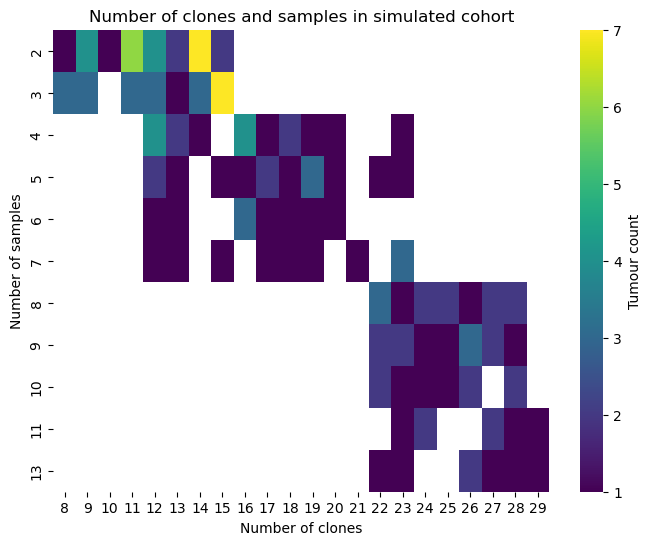

In [34]:
# Supplementary figure 2: simulated cohort overview
pivot_table = pd.read_csv(f'{output_directory}/simulations/simulations_default/cohort_outputs/simulated_cohort_overview.csv',index_col=0)
mask = pivot_table == 0
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, cmap='viridis', annot=False, cbar_kws={'label': 'Tumour count'}, mask=mask)
plt.title('Number of clones and samples in simulated cohort')
plt.xlabel('Number of clones')
plt.ylabel('Number of samples')
plt.savefig(f'../../figures/Suppfig2b_simulated_cohort_overview.pdf')

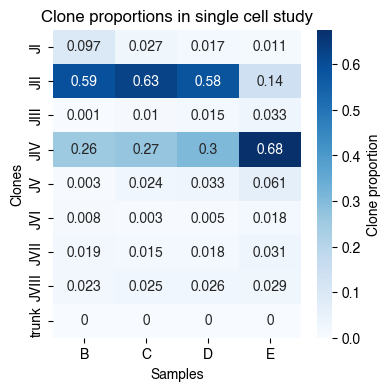

In [35]:
# Supplementary figure 2: single cell clone proportions
selected_tumours = ['S0noise0.1']
input_data_directory = f'{output_directory}/single_cell/single_cell_default/patient_outputs'
cp_table = pd.read_csv(f'{input_data_directory}/cp_table.csv',index_col='clone')
cp_table = cp_table.round(3)
plt.figure(figsize=(4, 4))
plt.rcParams['font.family'] = 'Helvetica'
sns.heatmap(cp_table, cmap='Blues', annot=True, cbar_kws={'label': 'Clone proportion'})
plt.title('Clone proportions in single cell study')
plt.xlabel('Samples')
plt.ylabel('Clones')
plt.savefig(f'../../figures/Suppfig2i_single_cell_clone_proportions.pdf')

In [37]:
# Supplementary Figure 1: simulations example case:
import SIMULATIONS_make_example_case_heatmaps
tumour_id='LTXSIM127'
base_dir = '../../_assets/example_heatmaps'
input_data_directory = f'{base_dir}/input/'
cohort_results_file = f'{output_directory}/simulations/simulations_default/cohort_outputs/combined.csv'
chr_table_file = f'{output_directory}/../_assets/chr_len.csv'
wgd_calls = f'{output_directory}/simulations/simulations_default/cohort_outputs/wgd_calls.csv'

wgd_calls = pd.read_csv(wgd_calls)
cohort_results = pd.read_csv(cohort_results_file)
tumour_input_directory = f'{input_data_directory}/{tumour_id}'
true = pd.read_csv(f'{tumour_input_directory}/copynumbers.csv')
true = SIMULATIONS_make_example_case_heatmaps.true_unify_format(true)
tumour_wgd_calls = wgd_calls[wgd_calls.tumour_id == tumour_id]
wgd_clones = list(tumour_wgd_calls[tumour_wgd_calls.GD > 0].clones)
alpaca_output = cohort_results[cohort_results.tumour_id==tumour_id]
alpaca_output = alpaca_output[alpaca_output.clone!='diploid']
# use loss_gain heatmap - use up to 8 colours, but use only up to max_cn
from python_functions import get_colourmap,create_seaborn_colour_map
max_cn_colour_boundry = 8
loss_gain_cmap = get_colourmap(max_cn_colour_boundry+1,testing=False,cn_type='allele')
sns_cmap = create_seaborn_colour_map(loss_gain_cmap, max_cn_colour_boundry+1)
sns_cmap[1] = (1.0, 1.0, 1.0) # ensure 1 is white
max_cn = alpaca_output[['pred_CN_A','pred_CN_B']].max().max()
# use only first 5 clours:
sns_cmap = sns.color_palette(sns_cmap[0:int(max_cn+1)])
heatmap_A = SIMULATIONS_make_example_case_heatmaps.plot_heatmap_with_tree_compare_with_true_solution_publication(alpaca_output=alpaca_output,input_data_directory=tumour_input_directory, chr_table_file=chr_table_file,wgd_clones=wgd_clones, max_cpn_cap=8, allele='A', true_solution_df=true, plot_comparison=True, sort_alleles=False,color_map=sns_cmap)
heatmap_A.fig.write_image(f'../../figures/Suppfig1c_ALPACA_simulations_{tumour_id}_A_example_heatmap.pdf')
heatmap_B = SIMULATIONS_make_example_case_heatmaps.plot_heatmap_with_tree_compare_with_true_solution_publication(alpaca_output=alpaca_output,input_data_directory=tumour_input_directory, chr_table_file=chr_table_file,wgd_clones=wgd_clones, max_cpn_cap=8, allele='B', true_solution_df=true, plot_comparison=True, sort_alleles=False,color_map=sns_cmap)
heatmap_B.fig.write_image(f'../../figures/Suppfig1d_ALPACA_simulations_{tumour_id}_B_example_heatmap.pdf')

ImportError: cannot import name 'get_colourmap' from 'python_functions' (/Users/piotrpawlik/Documents/GitHub/ALPACA-paper/bin/ANALYSIS/python_functions.py)

In [ ]:
# Supplementary figure 2: simulations example case:
import SIMULATIONS_make_example_case_heatmaps
tumour_id='LTXSIM127'
input_data_directory = f'{output_directory}/simulations/simulations_default/patient_outputs'
cohort_results_file = f'{output_directory}/simulations/simulations_default/cohort_outputs/combined.csv'
chr_table_file = f'{output_directory}/../_assets/chr_len.csv'
wgd_calls = f'{output_directory}/simulations/simulations_default/cohort_outputs/wgd_calls.csv'
wgd_calls = pd.read_csv(wgd_calls)
cohort_results = pd.read_csv(cohort_results_file)
tumour_input_directory = f'{input_data_directory}/{tumour_id}'
true = pd.read_csv(f'{tumour_input_directory}/copynumbers.csv')
true = SIMULATIONS_make_example_case_heatmaps.true_unify_format(true)
tumour_wgd_calls = wgd_calls[wgd_calls.tumour_id == tumour_id]
wgd_clones = list(tumour_wgd_calls[tumour_wgd_calls.GD > 0].clones)
alpaca_output = cohort_results[cohort_results.tumour_id==tumour_id]
alpaca_output = alpaca_output[alpaca_output.clone!='diploid']
heatmap_A = SIMULATIONS_make_example_case_heatmaps.plot_heatmap_with_tree_compare_with_true_solution_publication(alpaca_output=alpaca_output,input_data_directory=tumour_input_directory, chr_table_file=chr_table_file,wgd_clones=wgd_clones, max_cpn_cap=8, allele='A', true_solution_df=true, plot_comparison=True, sort_alleles=False)
heatmap_A.fig.write_image(f'../../figures/Suppfig2e_ALPACA_simulations_{tumour_id}_A_example_heatmap.pdf')
heatmap_B = SIMULATIONS_make_example_case_heatmaps.plot_heatmap_with_tree_compare_with_true_solution_publication(alpaca_output=alpaca_output,input_data_directory=tumour_input_directory, chr_table_file=chr_table_file,wgd_clones=wgd_clones, max_cpn_cap=8, allele='B', true_solution_df=true, plot_comparison=True, sort_alleles=False)
heatmap_B.fig.write_image(f'../../figures/Suppfig2f_ALPACA_simulations_{tumour_id}_B_example_heatmap.pdf')

In [ ]:
# Supplementary figure 2: comparison with TUSV-ext
import pandas as pd
import os
import networkx as nx
from functions import compare_copynumber_profiles,get_proportions_whole_tumour
from metrics_functions import get_distance_metrics,get_comparison_dfs

def convert_clone_proportions(output_path_tumour,vcf_file_names):
    clone_proportions = pd.read_csv(f'{output_path_tumour}/U.tsv',sep='\t',header=None)
    clone_proportions.columns = [f'clone{i}' for i in clone_proportions.columns]
    clone_proportions = clone_proportions.T
    clone_proportions.columns = [x.replace('.vcf','') for x in vcf_file_names]
    clone_proportions = clone_proportions.reset_index().rename(columns={'index':'clone'})
    return clone_proportions



def convert_vcf(vcf_input_path,vcf_file_names):
    vcf_input = pd.read_csv(f'{vcf_input_path}/{vcf_file_names[0]}',sep='\t',header=None,comment='#')
    vcf_input = vcf_input [[0,1,2,7]]
    vcf_input.columns = ['chromosome', 'start_pos', 'event_id', 'INFO']
    vcf_input = vcf_input[vcf_input['event_id'].str.contains('cnv')]
    vcf_input['end_pos'] = vcf_input['INFO'].str.split(';').str[0].str.split('=').str[1].astype(int)
    vcf_input = vcf_input.drop(columns=['INFO'])
    return vcf_input


def dot_to_paths(dot_content):
    graph = nx.DiGraph(nx.drawing.nx_pydot.read_dot(dot_content))
    root = [node for node in graph.nodes if graph.in_degree(node) == 0]
    if not root:
        raise ValueError("No root found in the graph.")
    root = root[0]
    def find_paths(node):
        successors = list(graph.successors(node))
        if not successors:  # Leaf node
            return [[node]]
        paths = []
        for succ in successors:
            for path in find_paths(succ):
                paths.append([node] + path)
        return paths
    tree = find_paths(root)
    for path in tree:
        for i in range(len(path)):
            path[i] = "clone"+path[i]
    return tree


def convert_copynumbers(output_path_tumour,vcf_input):
    TUSVEXT_copynumbers = pd.read_csv(f'{output_path_tumour}/C.tsv',sep='\t',header=None)
    info_file = pd.read_csv(f'{output_path_tumour}/F_info_phasing.csv',sep='\t',header=None,names=['chromosome','start_pos','event_id'])
    # variables need to retrieve minor and major allele columns:
    l_var = info_file['event_id'].str.contains('sv').sum() # number of sampled breakpoints
    g_var =  info_file['event_id'].str.contains('snv').sum()# number of sampled SNVs
    r_var = info_file[info_file['event_id'].str.contains('cnv')]['event_id'].nunique()# number of sampled CNAs
    assert l_var+g_var+(2*r_var) == TUSVEXT_copynumbers.shape[1]
    TUSVEXT_copynumbers.columns = info_file['event_id']
    TUSVEXT_copynumbers = TUSVEXT_copynumbers.T
    TUSVEXT_copynumbers.columns = [f'clone{i}' for i in TUSVEXT_copynumbers.columns]
    TUSVEXT_copynumbers['allele'] = ''
    TUSVEXT_copynumbers.reset_index(inplace=True)
    TUSVEXT_copynumbers.loc[l_var+g_var:l_var+g_var+r_var,'allele'] = 'A'
    TUSVEXT_copynumbers.loc[l_var+g_var+r_var:l_var+g_var+2*r_var, 'allele'] = 'B'
    TUSVEXT_copynumbers = TUSVEXT_copynumbers[TUSVEXT_copynumbers['allele']!='']
    # assign segment ids:
    TUSVEXT_copynumbers_long = TUSVEXT_copynumbers.melt(id_vars=['event_id','allele'],value_vars=[i for i in TUSVEXT_copynumbers.columns if 'clone' in i],var_name='clone',value_name='copy_number')
    TUSVEXT_copynumbers_af = TUSVEXT_copynumbers_long.pivot(index=['event_id', 'clone'], columns='allele', values='copy_number').reset_index()
    TUSVEXT_copynumbers_af.columns = ['event_id', 'clone', 'pred_CN_A', 'pred_CN_B']
    TUSVEXT_copynumbers_af = TUSVEXT_copynumbers_af.merge(vcf_input)
    # correct start_pos and end_pos so that segment names match with alpaca
    TUSVEXT_copynumbers_af['end_pos'] = TUSVEXT_copynumbers_af['end_pos'].astype(int)+1
    TUSVEXT_copynumbers_af.loc[TUSVEXT_copynumbers_af['start_pos'] == 1,'start_pos'] = 0
    TUSVEXT_copynumbers_af['segment'] = TUSVEXT_copynumbers_af['chromosome'].astype(str)+'_'+TUSVEXT_copynumbers_af['start_pos'].astype(str)+'_'+TUSVEXT_copynumbers_af['end_pos'].astype(str)
    TUSVEXT_copynumbers_af.sort_values(['chromosome','start_pos'],inplace=True)
    TUSVEXT_copynumbers_af.drop(columns=['event_id'],inplace=True)
    
    return TUSVEXT_copynumbers_af


def convert_tusvext_to_alpaca(tumour_id,publication_dir):
    output_path_tumour = f'{publication_dir}/_assets/tusvext/output/{tumour_id}'
    vcf_input_path = f'{publication_dir}/_assets/tusvext/input/{tumour_id}'
    vcf_file_names = [x for x in os.listdir(vcf_input_path) if 'vcf' in x]
    # convert clone proportions
    clone_proportions = convert_clone_proportions(output_path_tumour,vcf_file_names)
    # get segment identity
    vcf_input = convert_vcf(vcf_input_path,vcf_file_names)
    # convert tree
    tree_path = f'{output_path_tumour}/T.dot'
    tree = dot_to_paths(tree_path)
    # convert copynumbers
    TUSVEXT_copynumbers_af = convert_copynumbers(output_path_tumour,vcf_input)
    return clone_proportions,tree,TUSVEXT_copynumbers_af



from plotting_functions import make_error_comparison_plot
palette_path = f'../../_assets/publication_palette.json'

In [ ]:
cohort='H2'
run_name='default'
overwrite = False
simulations_input_path = f'../../_assets/tx_analysis'
publication_dir = f'../..'
alpaca_input_dir = f'../../_assets/benchmarking/H2/alpaca_input'
alpaca_output_dir = f'../../_assets/benchmarking/H2/alpaca_output'
tusvext_output_dir = f'../../_assets/tusvext'
processed_files_path = f'../../_assets/tusvext/data'
os.makedirs(processed_files_path, exist_ok=True)

In [ ]:
all_tumour_results = []
tumour_ids = os.listdir(f'{tusvext_output_dir}/output')
for tumour_id in tumour_ids:
    output_path_tumour = f'{tusvext_output_dir}/output/{tumour_id}/F.tsv'
     # if TUSVext output is missing, skip:
    if not os.path.exists(output_path_tumour):
        continue
    results_dict = {}
    processed_output_name = f'{processed_files_path}/{tumour_id}_matching_comparison.csv'
    if os.path.exists(processed_output_name) and not overwrite:
        results_df = pd.read_csv(processed_output_name)
        all_tumour_results.append(results_df)
    else:
        ALPACA_input = pd.read_csv(f'{alpaca_input_dir}/{tumour_id}/ALPACA_input_table.csv')
        ALPACA_output = pd.read_csv(f'{alpaca_output_dir}/patient_outputs/{tumour_id}/final_{tumour_id}.csv').drop_duplicates()
        ALPACA_output = ALPACA_output[ALPACA_output.clone!='diploid']
        comparator_name = 'TUSVext'
        _,_,COMPARATOR_output = convert_tusvext_to_alpaca(tumour_id,publication_dir)
        COMPARATOR_output = COMPARATOR_output[COMPARATOR_output['clone']!='diploid']
        TRUE_copynumbers = pd.read_csv(f'{alpaca_input_dir}/{tumour_id}/copynumbers.csv')
        patient_output_path =  f'{alpaca_output_dir}/patient_outputs/{tumour_id}/'
        simulations_path = f'{simulations_input_path}/{tumour_id}/sim'
        true_props_path =  f'{simulations_path}/{tumour_id}_cloneprops.tsv'
        conipher_props_path = f'{alpaca_input_dir}/{tumour_id}/cp_table.csv'
        common_segments = set.intersection(set(COMPARATOR_output['segment']), set(ALPACA_output['segment']), set(TRUE_copynumbers['segment']))
        TRUE_copynumbers = TRUE_copynumbers[TRUE_copynumbers['segment'].isin(common_segments)]
        ALPACA_output = ALPACA_output[ALPACA_output['segment'].isin(common_segments)]
        COMPARATOR_output = COMPARATOR_output[COMPARATOR_output['segment'].isin(common_segments)]
        alpaca_score = compare_copynumber_profiles(TRUE_copynumbers,ALPACA_output,metric='hamming')['closest_clone_distance'].mean()
        comparator_score = compare_copynumber_profiles(TRUE_copynumbers,COMPARATOR_output,metric='hamming')['closest_clone_distance'].mean()
        results_dict[tumour_id] = {'alpaca_score':alpaca_score, f'{comparator_name}':comparator_score}
        results_df = pd.DataFrame(results_dict).T.reset_index()
        results_df.to_csv(processed_output_name,index=False)
        all_tumour_results.append(results_df)
matching_distance_results = pd.concat(all_tumour_results)
# TVD
all_results=[]
tumour_ids = matching_distance_results['index']
for tumour_id in tumour_ids:
    results_tumour_path = f'{processed_files_path}/{tumour_id}_distance_metrics.csv'
    if os.path.exists(results_tumour_path):
        results_tumour = pd.read_csv(results_tumour_path)
        all_results.append(results_tumour)
        continue
    results_tumour = []
    print(tumour_id)
    TRUE_copynumbers = pd.read_csv(f'{alpaca_input_dir}/{tumour_id}/copynumbers.csv')
    TRUE_proportions = get_proportions_whole_tumour(pd.read_csv(f'{alpaca_input_dir}/{tumour_id}/true_proportions.csv'))
    TRUE_proportions['clone'] = 'clone'+TRUE_proportions['clone'].astype(str) if 'clone' not in str(TRUE_proportions.clone.iloc[0]) else TRUE_proportions['clone']
    ALPACA_output = pd.read_csv(f'{alpaca_output_dir}/patient_outputs/{tumour_id}/final_{tumour_id}.csv').drop_duplicates()
    ALPACA_output = ALPACA_output[ALPACA_output.clone!='diploid']
    CONIPHER_proportions = get_proportions_whole_tumour(pd.read_csv(f'{alpaca_input_dir}/{tumour_id}/cp_table.csv'))
    COMPARATOR_proportions,_,COMPARATOR_output = convert_tusvext_to_alpaca(tumour_id,publication_dir)
    COMPARATOR_output = COMPARATOR_output[COMPARATOR_output['clone']!='diploid']
    COMPARATOR_proportions = get_proportions_whole_tumour(COMPARATOR_proportions)
    res_df = COMPARATOR_output.merge(COMPARATOR_proportions, on='clone')
    common_segments = set.intersection(set(COMPARATOR_output['segment']), set(ALPACA_output['segment']), set(TRUE_copynumbers['segment']))
    TRUE_copynumbers = TRUE_copynumbers[TRUE_copynumbers['segment'].isin(common_segments)]
    ALPACA_output = ALPACA_output[ALPACA_output['segment'].isin(common_segments)]
    COMPARATOR_output = COMPARATOR_output[COMPARATOR_output['segment'].isin(common_segments)]
    for seg_ind,segment in enumerate(common_segments):
        true_copynumbers_seg = TRUE_copynumbers.query('segment == @segment')
        alpaca_segment = ALPACA_output.query('segment == @segment')
        comparator_segment = COMPARATOR_output.query('segment == @segment')
        #calculate scores for alpaca
        comparison_df_A,comparison_df_B = get_comparison_dfs(true_copynumbers_seg,TRUE_proportions,alpaca_segment,CONIPHER_proportions)
        output_df_alpaca = get_distance_metrics(comparison_df_A,comparison_df_B,tumour_id,segment)
        output_df_alpaca['model'] = 'ALPACA'
        #calculate scores for TUSVext
        comparison_df_A,comparison_df_B = get_comparison_dfs(true_copynumbers_seg,TRUE_proportions,comparator_segment,COMPARATOR_proportions)
        output_df_comparator = get_distance_metrics(comparison_df_A,comparison_df_B,tumour_id,segment)
        output_df_comparator['model'] = 'TUSVext'
        output_df = pd.concat([output_df_alpaca,output_df_comparator])
        results_tumour.append(output_df)
    results_tumour = pd.concat(results_tumour)
    results_tumour.to_csv(results_tumour_path,index=False)
    all_results.append(results_tumour)
distance_results = pd.concat(all_results)


In [ ]:
matching_distance_results.rename(columns={'alpaca_score':'alpaca','TUSVext':'hatchet'},inplace=True)
w=400
h=600
lables_font_size=25
annotation_font_size=12
scale=1
fig_H, results = make_error_comparison_plot(
    cohort_results=matching_distance_results,
    palette_path=palette_path,
    y_axis_title='Mean Hamming distance<br>to matching true CN profile',
    w=w,
    h=h,
    font_size=lables_font_size,orientation='v')
fig_H.update_traces(name="TUSV-ext", selector=dict(name="HATCHet"))
fig_H.write_image(f'../../figures/Suppfig2g_hamming_comparison_boxplot_alpaca_vs_tusvext.pdf', width=w, height=h,scale=scale)
fig_H.show()




In [ ]:
distance_results_transformed = distance_results.groupby(['tumour_id','model']).apply(lambda x: x['total_var_dist_mean'].mean()).reset_index().rename(columns={0:'total_var_dist_mean'})
distance_results_transformed_wide = distance_results_transformed.pivot(index='tumour_id',columns='model',values='total_var_dist_mean').reset_index()
distance_results_transformed_wide.rename(columns={'ALPACA':'alpaca','TUSVext':'hatchet'},inplace=True)
w=400
h=600
lables_font_size=25
annotation_font_size=12
scale=1
fig_T, results = make_error_comparison_plot(
    cohort_results=distance_results_transformed_wide,
    palette_path=palette_path,
    y_axis_title='Mean Total Variation Distance<br>to true CN solution',
    w=w,
    h=h,
    font_size=lables_font_size,orientation='v')
fig_T.update_traces(name="TUSV-ext", selector=dict(name="HATCHet"))
fig_T.write_image(f'../../figures/Suppfig2h_TVD_comparison_boxplot_alpaca_vs_tusvext.pdf', width=w, height=h,scale=scale)
fig_T.show()